It's advisable to run this notebook in colab with GPU enabled. In order to use this locally, you may require to install PyTorch (GPU) that will be quite troublesome to setup for innitial (Required to install CUDA, CUDNN)

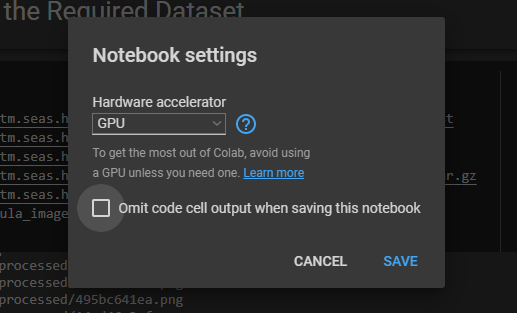

# Downloading the Required Dataset

In [1]:
!mkdir dataset
%cd dataset
!wget http://lstm.seas.harvard.edu/latex/data/im2latex_validate_filter.lst
!wget http://lstm.seas.harvard.edu/latex/data/im2latex_train_filter.lst
!wget http://lstm.seas.harvard.edu/latex/data/im2latex_test_filter.lst
!wget http://lstm.seas.harvard.edu/latex/data/formula_images_processed.tar.gz
!wget http://lstm.seas.harvard.edu/latex/data/im2latex_formulas.norm.lst
!tar -zxvf formula_images_processed.tar.gz 
%cd ..

Streaming output truncated to the last 5000 lines.
formula_images_processed/410b27570c.png
formula_images_processed/787db8af51.png
formula_images_processed/5591917116.png
formula_images_processed/7f14ce8f69.png
formula_images_processed/256b167327.png
formula_images_processed/71500ed50a.png
formula_images_processed/71620990cc.png
formula_images_processed/5c355acac8.png
formula_images_processed/1051679595.png
formula_images_processed/32b2b8a061.png
formula_images_processed/52082547a6.png
formula_images_processed/561cde56ac.png
formula_images_processed/e524371a37.png
formula_images_processed/39a2035e7b.png
formula_images_processed/657ff86419.png
formula_images_processed/4b25c8f837.png
formula_images_processed/115c24ae0c.png
formula_images_processed/2e5ab7abc4.png
formula_images_processed/430c94b6c5.png
formula_images_processed/275732ecef.png
formula_images_processed/6d0c3b1cca.png
formula_images_processed/1ef1e76652.png
formula_images_processed/21461a3038.png
formula_images_processed/6854

In [2]:
DATA_DIR = "/content/dataset"

# Get the Vocablary

We will record the frequency of each symbol and only store the symbol in the vocablary if it has minimum amount of frequency (certain threshold is reached)

In [3]:
vocab = dict()

SOS_TOKEN = '<SOS>'
EOS_TOKEN = '<EOS>'
PAD_TOKEN = '<PAD>'
UNK_TOKEN = '<UNK>'

vocab[PAD_TOKEN] = 0
vocab[SOS_TOKEN] = 1
vocab[EOS_TOKEN] = 2
vocab[UNK_TOKEN] = 3

length = 4
threshold = 5

frequency = dict()

def get_vocab(path, vocab, length):

  with open(f"{DATA_DIR}/im2latex_formulas.norm.lst", 'r') as f:
    formulas = f.read().strip('\n').split("\n")

  data = list()

  with open (f"{DATA_DIR}/{path}") as t:
    temp_list = t.read().split("\n")
    for each_info in temp_list:
      try:  
        img_name, idx = each_info.split(" ")
      except:
        print(f"Skipped : {each_info}")
        continue

      respective_formula = formulas[int(idx)]
      for each_sym in respective_formula.split():
        if each_sym in frequency:
          frequency[each_sym] += 1
        else:
          frequency[each_sym] = 1

        if frequency[each_sym] == threshold:
          vocab[each_sym] = length
          length += 1

      data.append([img_name, respective_formula])
  return data, vocab, length

train_data, vocab, length = get_vocab("im2latex_train_filter.lst", vocab, length)
valid_data, vocab, length = get_vocab("im2latex_validate_filter.lst", vocab, length)

idx_to_vocab = {values:keys for keys, values in vocab.items()}

Skipped : 
Skipped : 


In [6]:
print(f"Total Unique symbols: {len(frequency)}")
print(f"Total Unique symbols in vocablary: {len(vocab)}")

Total Unique symbols: 547
Total Unique symbols in vocablary: 444


As we'll go futher, you'll realize remaining symbols will be replaced with UNK token.

We added 3 more tokens here i.e., SOS that is start of the statement, EOS that is end of the statement and PAD that will be used to pad that statements to the length of max_len of statement in the batch

# Load required libraries

In [7]:
!pip install -q albumentations==0.4.5

     |████████████████████████████████| 122kB 8.2MB/s 
     |████████████████████████████████| 634kB 33.6MB/s 


In [8]:
import cv2
import time

import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
import torch.nn as nn
from torch.nn import init

import torch.nn.functional as F

from torch.utils.data import Dataset
from torch.nn.utils.rnn import pad_sequence

from tqdm import tqdm_notebook

def seed_everything(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(42)

# Dataloader

Dataloader loads the data in batches, preparing for the model. 

Here we resized every image to a specific size. 

We tokenized the formulas and numericalized  i.e., replaced the characters with the respective number from the vocab. 

Then SOS and EOS tokens were added in the begining and ending of the sentence.

After the batches are formed, formulas's lengths won't be the same throughout the batch. So, we padded them batch wise. For this we used collate_fn (checkout collate class for the implementation)

In [9]:
def train_augmentaions(img_size = (150,150)):
      return A.Compose([
              A.Resize(height=img_size[0], width=img_size[1], p=1), #Resizing every image to same img_size
              A.Normalize(),
              ToTensorV2(p=1.0),                  
          ], p=1.0)

class DatasetGenerator(Dataset):
    def __init__(self, array, vocab, transforms):

        self.array = array
        self.vocab = vocab
        self.transforms = transforms

    def __getitem__(self, index):
        data = self.array[index]
        img_name, formula = data

        img = cv2.imread(f"{DATA_DIR}/formula_images_processed/{img_name}")
  
        if self.transforms:
          sample = {'image': img}
          sample = self.transforms(**sample)
          img = sample['image']

        numeralised_formula = [self.vocab[SOS_TOKEN]] + self.get_vector(formula) + [self.vocab[EOS_TOKEN]] #Appending start and end token

        return img, torch.tensor(numeralised_formula)

    def __len__(self):
        return len(self.array)

    def get_vector(self, formulas):
        return ([self.vocab[each_word] if each_word in self.vocab else self.vocab[UNK_TOKEN]for each_word in formulas.split()]) #UNK token if word not in vocab

class Collate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=True, padding_value=self.pad_idx) # Padding so that sequence length is consistant in a batch

        return imgs, targets

# Model

Basically it's the architecture described in the research paper.

We implemented a cnn that will give the image's features. Now, before passing them to seq decoder like we do in image caption papers, we used rnn encoder that re eoncoded each row of the grid from cnn output. 

We used bidirectional lstm with 256 hidden state size.

Then the output is passed to decoder class which uses lstm with 512 hidden state size. Used 80 size for embedding for text.

In [10]:
class Encoder(nn.Module):
  
  def __init__(self, rnn_embed_size=256, n_layer=1):
    super(Encoder, self).__init__()
    
    INIT = 1e-2
    self.cnn = nn.Sequential(
        
        nn.Conv2d(in_channels = 3, out_channels = 512, kernel_size = (3,3), stride = (1,1), padding=(0,0)),
        nn.BatchNorm2d(512),
        nn.ReLU(),

        nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = (3,3), stride = (1,1), padding = (1,1)),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = (1,2), stride = (1,2), padding = (0,0)),

        nn.Conv2d(in_channels = 512, out_channels = 256, kernel_size = (3,3), stride = (1,1), padding = (1,1)),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = (2,1), stride = (2,1), padding = (0,0)),

        nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = (3,3), stride = (1,1), padding = (1,1)),
        nn.BatchNorm2d(256),
        nn.ReLU(),

        nn.Conv2d(in_channels = 256, out_channels = 128, kernel_size = (3,3), stride = (1,1), padding = (1,1)),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = (2,2), stride = (2,2), padding = (0,0)),

        nn.Conv2d(in_channels = 128, out_channels = 64, kernel_size = (3,3), stride = (1,1), padding = (1,1)),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = (2,2), stride = (2,2), padding = (1,1)),
    )

    #For Row Encoder hidden layer
    self.hidden_layer_h = nn.Parameter(torch.Tensor(n_layer*2, rnn_embed_size))
    self.hidden_layer_c = nn.Parameter(torch.Tensor(n_layer*2, rnn_embed_size))

    #To aviod random initialization
    init.uniform_(self.hidden_layer_h, -INIT, INIT)
    init.uniform_(self.hidden_layer_c, -INIT, INIT)

    self.rnn = nn.LSTM(64, rnn_embed_size, bidirectional=True, batch_first=True)
  
  def forward(self, images):
    embedded_images = self.cnn(images) #[B, C, H, W] 
    embedded_images = embedded_images.permute(0, 2, 3, 1) #[B, H, W, C]

    B, H, W, C = embedded_images.size() # B 13 13 64

    embedded_images = embedded_images.contiguous().view(B*H, W, C)

    init_hidden_layer_h = self.hidden_layer_h.unsqueeze(1).expand(-1, B*H, -1).contiguous() #[B, 26, 256]
    init_hidden_layer_c = self.hidden_layer_c.unsqueeze(1).expand(-1, B*H, -1).contiguous()

    init_hidden_layer = (init_hidden_layer_h, init_hidden_layer_c)
    
    output, (hidden_layer_h,hidden_layer_c) = self.rnn(embedded_images, init_hidden_layer) #[26,13,512]

    output = output.view(B, H, W, -1) #[B,2,13,512]

    hidden_layer_h = hidden_layer_h.view(2, B, H, -1) #[B,2,13,256]
    hidden_layer_c = hidden_layer_c.view(2, B, H, -1)

    return output, (hidden_layer_h, hidden_layer_c)


In [11]:
class Decoder(nn.Module):

    def __init__(self, embed_size=80, hidden_size=512,rnn_embed_size=256, vocab_size=len(vocab), num_layers=1):
        super(Decoder, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.LSTMCell(embed_size+rnn_embed_size, hidden_size)
        self.linear_connector = nn.Linear(hidden_size+rnn_embed_size*2, rnn_embed_size)
        self.final = nn.Linear(rnn_embed_size, vocab_size)
        self.linear_connector2 = nn.Linear(hidden_size, rnn_embed_size)
        

    def forward(self, feature, text,last_hidden):
        qw=feature
        
        features = feature.mean(dim=[1, 2]) # [B, 512]
        
        h, c = last_hidden

        h = h.permute(1, 2, 0, 3).contiguous() #[B,13,2,256]
        h = h.view(h.size(0), h.size(1), -1) #[B, 13, 512] since rnn_embed_size = 256 and rnn_decoder = 512 
        h = h.mean(dim=1) # [B, 512]

        c = c.permute(1, 2, 0, 3).contiguous() #[B,13,2,256]
        c = c.view(c.size(0), c.size(1), -1) #[B, 13, 512] since rnn_embed_size = 256 and rnn_decoder = 512 
        c = c.mean(dim=1) # [B, 512]

        features = self.linear_connector(torch.cat([h, features], dim=1)) #[B, 256] Used this to scale back encoder output to 256. added "h" to preserve features
        
        batch_max_len = text.size(1)

        res = list()

        for t in range(batch_max_len):
          current_text = text[:, t:t+1] 

          prev_y = self.embedding(current_text).squeeze(1) #[B, 80]
          input = torch.cat([prev_y, features], dim=1)  # [B, 80+256]

          h_t, c_t = self.rnn(input, (h,c))
    
          caat = self.linear_connector2(h_t).tanh()

          output = self.final(caat)

          logit = F.softmax(output, dim=1)
          res.append(logit)

        res = torch.stack(res, dim=1)

        return res

In [12]:
class Model(nn.Module):
  def __init__(self):
    super(Model, self).__init__()

    self.encoder = Encoder()
    self.decoder = Decoder()

  def forward(self, images, text):

    outputs,hidden_states = self.encoder(images)
    logits = self.decoder(outputs,text,hidden_states)
    
    return logits

# Config

In [13]:
class Config:

  num_workers=4
  batch_size=16

  n_epoches=1000

  lr = 0.0003

  patience=5 # Early stopping
  
  SchedulerClass = torch.optim.lr_scheduler.ReduceLROnPlateau
  scheduler_params = dict(
      mode='min',
      factor=0.8,
      patience=1,
      verbose=True, 
      threshold=0.0001,
      threshold_mode='abs',
      cooldown=0, 
      min_lr=1e-8,
      eps=1e-08
  )

# Engine

This is the engine or trainer. It'll start the training process.

We used adam as optimizer, CrossEntropy as loss function, and ReducedLRonPlateau as LR scheduler 

In [14]:
train_loss=dict()
valid_loss=dict()

class Engine:
    
    def __init__(self,device,config,model, weight_path='./'):
  
        self.device=device
        self.config=config
        self.best_score=0
        self.best_loss=5000
        self.weight_path = weight_path

        self.model = model
        
        param_optimizer = list(self.model.named_parameters())
        no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
            {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ] 
        
        self.optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=config.lr)

        self.scheduler = config.SchedulerClass(self.optimizer, **config.scheduler_params)
        
        self.criterion = nn.CrossEntropyLoss().to(self.device)
        
    def fit(self,train_loader,validation_loader):
        for epoch in range(self.config.n_epoches):

            print("Training Started...")
            t=time.time()
            summary_loss = self.train_one_epoch(train_loader)
            train_loss[epoch] = summary_loss.avg

            print('Train : Epoch {:03}: | Summary Loss: {:.3f} | Training time: {}'.format(epoch,summary_loss.avg,time.time() - t))
            
            t=time.time()
            print("Validation Started...")
            summary_loss = self.validation(validation_loader)
            valid_loss[epoch] = summary_loss.avg

            print('Valid : Epoch {:03}: | Summary Loss: {:.3f} | Training time: {}'.format(epoch,summary_loss.avg,time.time() - t))
            
            self.scheduler.step(metrics=summary_loss.avg)
            
            if not self.best_score:
                self.best_score = summary_loss.avg  # So any validation roc_auc we have is the best one for now
                print('Saving model with best val as {}'.format(self.best_score))
                self.model.eval()   
                patience = self.config.patience
                torch.save({'model_state_dict': self.model.state_dict(),'best_score': self.best_score, 'epoch': epoch},  f"{self.weight_path}/_DD.pt")
                continue  

            if summary_loss.avg <= self.best_score:
                self.best_score = summary_loss.avg
                patience = self.config.patience  # Resetting patience since we have new best validation accuracy
                print('Imporved model with best val as {}'.format(self.best_score))
                torch.save({'model_state_dict': self.model.state_dict(),'best_score': self.best_score, 'epoch': epoch},  f"{self.weight_path}/_DD.pt")
            else:
                patience -= 1
                print('Patience Reduced')
                if patience == 0:
                    print('Early stopping. Best Val roc_auc: {:.3f}'.format(self.best_score))
                    break
                    
    def validation(self, val_loader):
        self.model.eval()

        summary_loss = AverageMeter()

        t = time.time()

        for steps,(images, formulas) in enumerate(tqdm_notebook(val_loader)):
            with torch.no_grad():
                formulas = formulas.to(self.device, dtype=torch.long)
                batch_size = images.shape[0]               
                images = images.to(self.device, dtype=torch.float32)

                logits = self.model(images, formulas)
                
                padding = torch.ones_like(formulas) * vocab[PAD_TOKEN]
                mask = (formulas != padding)

                formulas = formulas.masked_select(mask)
                logits = logits.masked_select(mask.unsqueeze(2).expand(-1, -1, logits.size(2))).contiguous().view(-1, logits.size(2))

                loss = self.criterion(logits, formulas)

                summary_loss.update(loss.detach().item(), batch_size)

        return summary_loss


    def train_one_epoch(self, train_loader):
        self.model.train()

        summary_loss = AverageMeter()

        t = time.time()

        for steps,(images, formulas) in enumerate(tqdm_notebook(train_loader)):
            formulas = formulas.to(self.device, dtype=torch.long)
            batch_size = images.shape[0]               
            images = images.to(self.device, dtype=torch.float32)

            self.optimizer.zero_grad()

            logits = self.model(images, formulas)

            padding = torch.ones_like(formulas) * vocab[PAD_TOKEN]
            mask = (formulas != padding)

            formulas = formulas.masked_select(mask)
            logits = logits.masked_select(mask.unsqueeze(2).expand(-1, -1, logits.size(2))).contiguous().view(-1, logits.size(2))

            loss = self.criterion(logits, formulas)

            loss.backward()
            self.optimizer.step()

            summary_loss.update(loss.detach().item(), batch_size)

        return summary_loss

In [15]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# Driver

In [ ]:
train_dataset = DatasetGenerator(train_data, vocab, transforms=train_augmentaions())
valid_dataset = DatasetGenerator(valid_data, vocab, transforms=train_augmentaions())

train_loader = torch.utils.data.DataLoader(
          train_dataset,
          batch_size=Config.batch_size,
          collate_fn=Collate(vocab[PAD_TOKEN]),
          pin_memory=True,
          drop_last=True,
          num_workers=Config.num_workers,
      )

validation_loader = torch.utils.data.DataLoader(
          valid_dataset, 
          batch_size=Config.batch_size,
          num_workers=Config.num_workers,
          pin_memory=False,
          collate_fn=Collate(vocab[PAD_TOKEN]),
      ) 

model = Model().cuda()

engine = Engine(device=torch.device('cuda'), config=Config,model=model)
engine.fit(train_loader, validation_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Training Started...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:103: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Train : Epoch 000: | Summary Loss: 5.257 | Training time: 3503.783320426941
Validation Started...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Valid : Epoch 000: | Summary Loss: 5.106 | Training time: 133.23440146446228
Saving model with best val as 5.106474088967345
Training Started...



Train : Epoch 001: | Summary Loss: 5.103 | Training time: 3513.107255220413
Validation Started...



Valid : Epoch 001: | Summary Loss: 5.101 | Training time: 131.6291527748108
Imporved model with best val as 5.100928452422257
Training Started...


* Train : Epoch 000: | Summary Loss: 5.257 | Training time: 3503.783320426941


* Valid : Epoch 000: | Summary Loss: 5.106 | Training time: 133.23440146446228

Saving model with best val as 5.106474088967345



* Train : Epoch 001: | Summary Loss: 5.103 | Training time: 3513.107255220413


* Valid : Epoch 001: | Summary Loss: 5.101 | Training time: 131.6291527748108

Imporved model with best val as 5.100928452422257

Basically loss is reducing so our model is learning. 

Due to hardware constraints, it's not feasable to train this model. It took one hour for one epoch and colab disconnects after some hours as seen in the image.

But the next step is simple. 

* Just train the model to its full potential and finetune the model via hyperparameter tuning and different training configs. 
* Evaulate the model on test data. BLEU metric is suitable here. It's for evaluating a generated sentence to a reference sentence. Scores from 0.0-1.0 or 0-100
* Once satisfied with the results, can wrap up with flask to setup up a REST api and deploy it with an nginx server on any cloud service as per the needs.

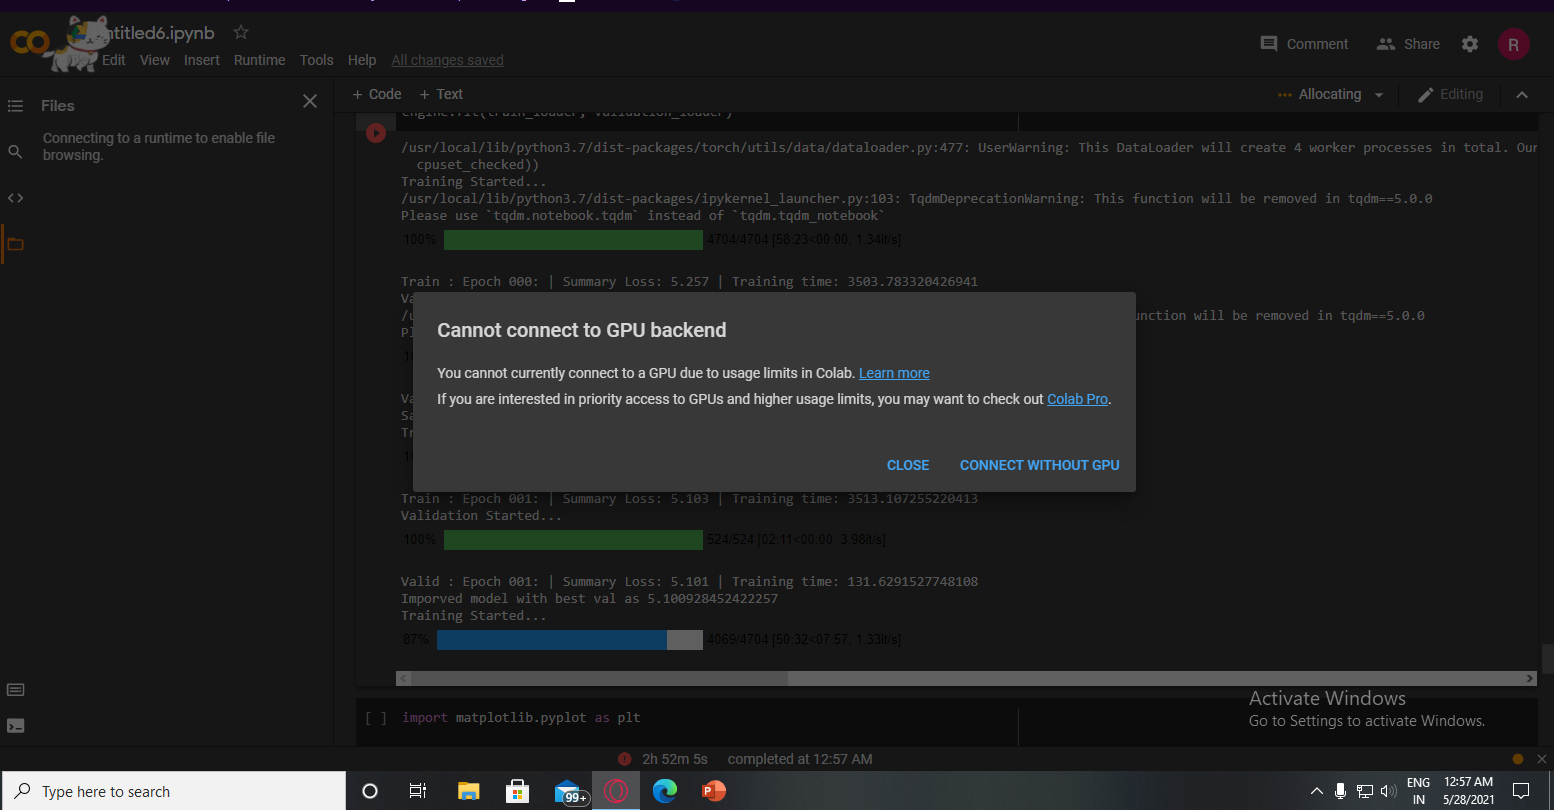

For the graph visualization, the below code snippet can be used after the training is completed.

In [ ]:
import matplotlib.pyplot as plt

plt.plot(list(train_loss.keys()), list(train_loss.values()), linewidth=1, label="Train")
plt.plot(list(valid_loss.keys()), list(valid_loss.values()),  linewidth=1, label="Validation")
plt.suptitle('Fold : 0 ')
plt.xlabel('Epoches')
plt.ylabel('Loss (Log scale)')
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.show()